<a href="https://colab.research.google.com/github/andrewcxjin/computer-vision-project/blob/claude%2Fuav-human-detection-notebook-7sh87/uav_human_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust Human Detection in UAV Imagery
## HIT-UAV Infrared Thermal Dataset - Baseline vs Augmented Comparison

**Experiment Design:**
- **Model A**: Trained on clean/normal data only
- **Model B**: Trained with SAR augmentations (snow, smoke/fire, thermal artifacts)
- **Evaluation**: Compare both on clean and perturbed test sets

**Dataset**: HIT-UAV from Kaggle (thermal infrared UAV imagery)

---

## Cell 1: Environment Setup

In [51]:
# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# =============================================================================

import subprocess
import sys
import os

def install_packages():
    """Install required packages."""
    packages = [
        'torch', 'torchvision', 'albumentations>=1.3.0', 'pycocotools',
        'opencv-python-headless', 'matplotlib', 'numpy', 'Pillow',
        'tqdm', 'scipy', 'kaggle'
    ]
    for pkg in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
    print("Packages installed")

install_packages()

# No Google Drive mounting; data is stored locally under Config.DATA_ROOT when running in Colab or locally.


Packages installed


## Cell 2: Imports and Configuration

In [52]:
# =============================================================================
# CELL 2: IMPORTS AND CONFIGURATION
# =============================================================================

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import shutil
import zipfile
import copy
from pathlib import Path
from tqdm.auto import tqdm
import random
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuration
class Config:
    # Paths
    IN_COLAB = bool(os.environ.get('COLAB_GPU') or os.environ.get('KAGGLE_KERNEL_RUN_TYPE') or 'google.colab' in str(getattr(__import__('sys'), 'modules', {})))
    BASE_DIR = Path('/content') if IN_COLAB else Path('.')
    DATA_ROOT = BASE_DIR / 'hit-uav'
    CHECKPOINT_DIR = BASE_DIR / 'checkpoints'
    OUTPUT_DIR = BASE_DIR / 'outputs'

    # Image settings
    IMG_SIZE = 512

    # Training settings
    BATCH_SIZE = 4
    NUM_EPOCHS = 6
    LR = 0.005
    LR_STEP_SIZE = 3
    LR_GAMMA = 0.1
    WEIGHT_DECAY = 0.0005

    # Detection settings
    NUM_CLASSES = 6  # background + 5 HIT-UAV classes
    IOU_THRESHOLD = 0.5
    CONF_THRESHOLD = 0.5

    # Flags
    USE_YOLO_DIRECT = True  # always use provided YOLO labels
    ENABLE_SYNTH_AUG = True  # overlay perturbations on all images when enabled

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42

# Set seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)
random.seed(Config.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Config.SEED)

# Ensure dirs
for p in [Config.DATA_ROOT, Config.CHECKPOINT_DIR, Config.OUTPUT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print(f"Device: {Config.DEVICE}")
print(f"Image size: {Config.IMG_SIZE}, Epochs: {Config.NUM_EPOCHS}, Batch: {Config.BATCH_SIZE}")
print(f"Data root: {Config.DATA_ROOT}")


Device: cuda
Image size: 512, Epochs: 6, Batch: 4
Data root: /content/hit-uav


## Cell 3: Download HIT-UAV Dataset from Kaggle

In [61]:
import tarfile
import subprocess
import sys
import os
import shutil
import zipfile
from pathlib import Path

def download_hituav_kaggle(data_root: Path) -> bool:
    """Download and unpack HIT-UAV dataset to the expected YOLO structure.
    Resulting layout:
    data_root/
      dataset.yaml
      images/
      labels/
    """
    data_root.mkdir(parents=True, exist_ok=True)
    images_dir = data_root / "images"
    labels_dir = data_root / "labels"
    zip_path = data_root / "hituav.zip"

    if images_dir.exists() and labels_dir.exists() and list(images_dir.glob('*')):
        print(f"Dataset already prepared at {data_root}")
        return True

    print("Downloading HIT-UAV dataset from Kaggle via curl...")
    try:
        # Original Kaggle URL can be problematic with curl, using direct download if available or alternative
        # For Colab, sometimes Kaggle API or direct download links are more reliable if you have credentials set up.
        # Given previous success with 'curl', let's assume it works or will be manually handled if it fails.
        subprocess.run([
            'curl', '-L', '-o', str(zip_path),
            'https://www.kaggle.com/api/v1/datasets/download/pandrii000/hituav-a-highaltitude-infrared-thermal-dataset'
        ], check=True, timeout=600)
    except Exception as e:
        print(f"Curl download failed: {e}")
        print("Please ensure you have authenticated Kaggle API or that the direct download link is valid.")
        return False

    if not zip_path.exists() or zip_path.stat().st_size < 1_000_000: # Check for reasonable size
        print("Download seems incomplete; aborting.")
        return False

    print("Extracting zip...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(data_root / 'raw')
        zip_path.unlink(missing_ok=True)
    except Exception as e:
        print(f"Error extracting zip: {e}")
        return False

    raw_root = data_root / 'raw'
    print(f"Contents of {raw_root}: {os.listdir(raw_root)}")

    candidate = None
    extracted_folders = [f for f in raw_root.iterdir() if f.is_dir()]
    if len(extracted_folders) == 1:
        sub_raw_root = extracted_folders[0]
        print(f"Detected single extracted folder: {sub_raw_root}")
        search_paths = [sub_raw_root]
    else:
        search_paths = [raw_root]

    # Iterate through potential roots to find 'images' and 'labels' directories
    for current_search_root in search_paths:
        # Use rglob to find 'images' and 'labels' directories anywhere within current_search_root
        for p_images in current_search_root.rglob('images'):
            # Check if there's a corresponding 'labels' directory at the same level as p_images
            # This implies the structure 'parent_folder/images' and 'parent_folder/labels'
            p_labels = p_images.parent / 'labels'
            if p_labels.exists():
                candidate = (p_images, p_labels)
                break
        if candidate:
            break

    if candidate is None:
        print("Could not locate images/labels directories after extraction in the expected structure.")
        print(f"Searched within: {search_paths}")
        return False

    src_images, src_labels = candidate
    print(f"Found source images directory: {src_images}")
    print(f"Found source labels directory: {src_labels}")

    images_dir.mkdir(exist_ok=True)
    labels_dir.mkdir(exist_ok=True)

    moved_images_count = 0
    print(f"Moving image files from {src_images}...")
    for f in tqdm(src_images.rglob('*'), desc="Moving images"):
        if f.is_file() and f.suffix.lower() in ['.jpg', '.png', '.jpeg']:
            shutil.move(str(f), images_dir / f.name)
            moved_images_count += 1
    print(f"Moved {moved_images_count} image files.")

    moved_labels_count = 0
    print(f"Moving label files from {src_labels}...")
    for f in tqdm(src_labels.rglob('*.txt'), desc="Moving labels"):
        if f.is_file(): # Ensure it's a file
            shutil.move(str(f), labels_dir / f.name)
            moved_labels_count += 1
    print(f"Moved {moved_labels_count} label files.")

    # Create minimal dataset.yaml for reference
    yaml_path = data_root / 'dataset.yaml'
    if not yaml_path.exists():
        class_names = ['person', 'car', 'bicycle', 'othervehicle', 'dontcare']
        yaml_content = """train: images\nval: images\ntest: images\n\nnames:\n""" + "\n".join([f"  {i}: {name}" for i, name in enumerate(class_names)]) + "\n"
        with open(yaml_path, 'w') as f:
            f.write(yaml_content)

    print(f"Prepared dataset at {data_root}")
    print(f" images: {len(list(images_dir.glob('*')))} | labels: {len(list(labels_dir.glob('*.txt')))}")

    return True

success = download_hituav_kaggle(Config.DATA_ROOT)
if not success:
    raise SystemExit("Dataset download/prep failed. Please ensure Kaggle API access is available.")

Dataset already prepared at /content/hit-uav


## Cell 4: Convert HIT-UAV to COCO Format (Person Only)

In [58]:

# =============================================================================
# CELL 4: DATASET SANITY CHECK (NO CONVERSION)
# =============================================================================

def show_dataset_overview(data_root: Path):
    images_dir = data_root / 'images'
    labels_dir = data_root / 'labels'
    image_files = sorted(list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png')))
    label_files = sorted(list(labels_dir.glob('*.txt')))
    print(f"Images: {len(image_files)}, Labels: {len(label_files)}")
    if image_files:
        print(f"Sample image: {image_files[0].name}")
    if label_files:
        print(f"Sample label: {label_files[0].name}")
        with open(label_files[0], 'r') as f:
            for line in f.readlines()[:5]:
                print('  ', line.strip())

show_dataset_overview(Config.DATA_ROOT)

IMAGES_DIR = Config.DATA_ROOT / 'images'
LABELS_DIR = Config.DATA_ROOT / 'labels'


Images: 2866, Labels: 2866
Sample image: 0_100_30_0_03280.jpg
Sample label: 0_100_30_0_03280.txt
   1 0.33671875 0.2353515625 0.0546875 0.060546875
   1 0.58359375 0.1904296875 0.0515625 0.060546875
   1 0.209375 0.2763671875 0.046875 0.060546875
   1 0.04921875 0.3896484375 0.0453125 0.056640625
   1 0.0671875 0.3759765625 0.05625 0.064453125


## Cell 5: SAR Augmentations

Visualizing SAR augmentations on actual dataset images

Showing 4 random images from the dataset:
  - 1_60_70_0_00571.jpg
  - 0_60_90_0_01813.jpg
  - 1_60_50_0_00366.jpg
  - 1_60_50_0_00311.jpg


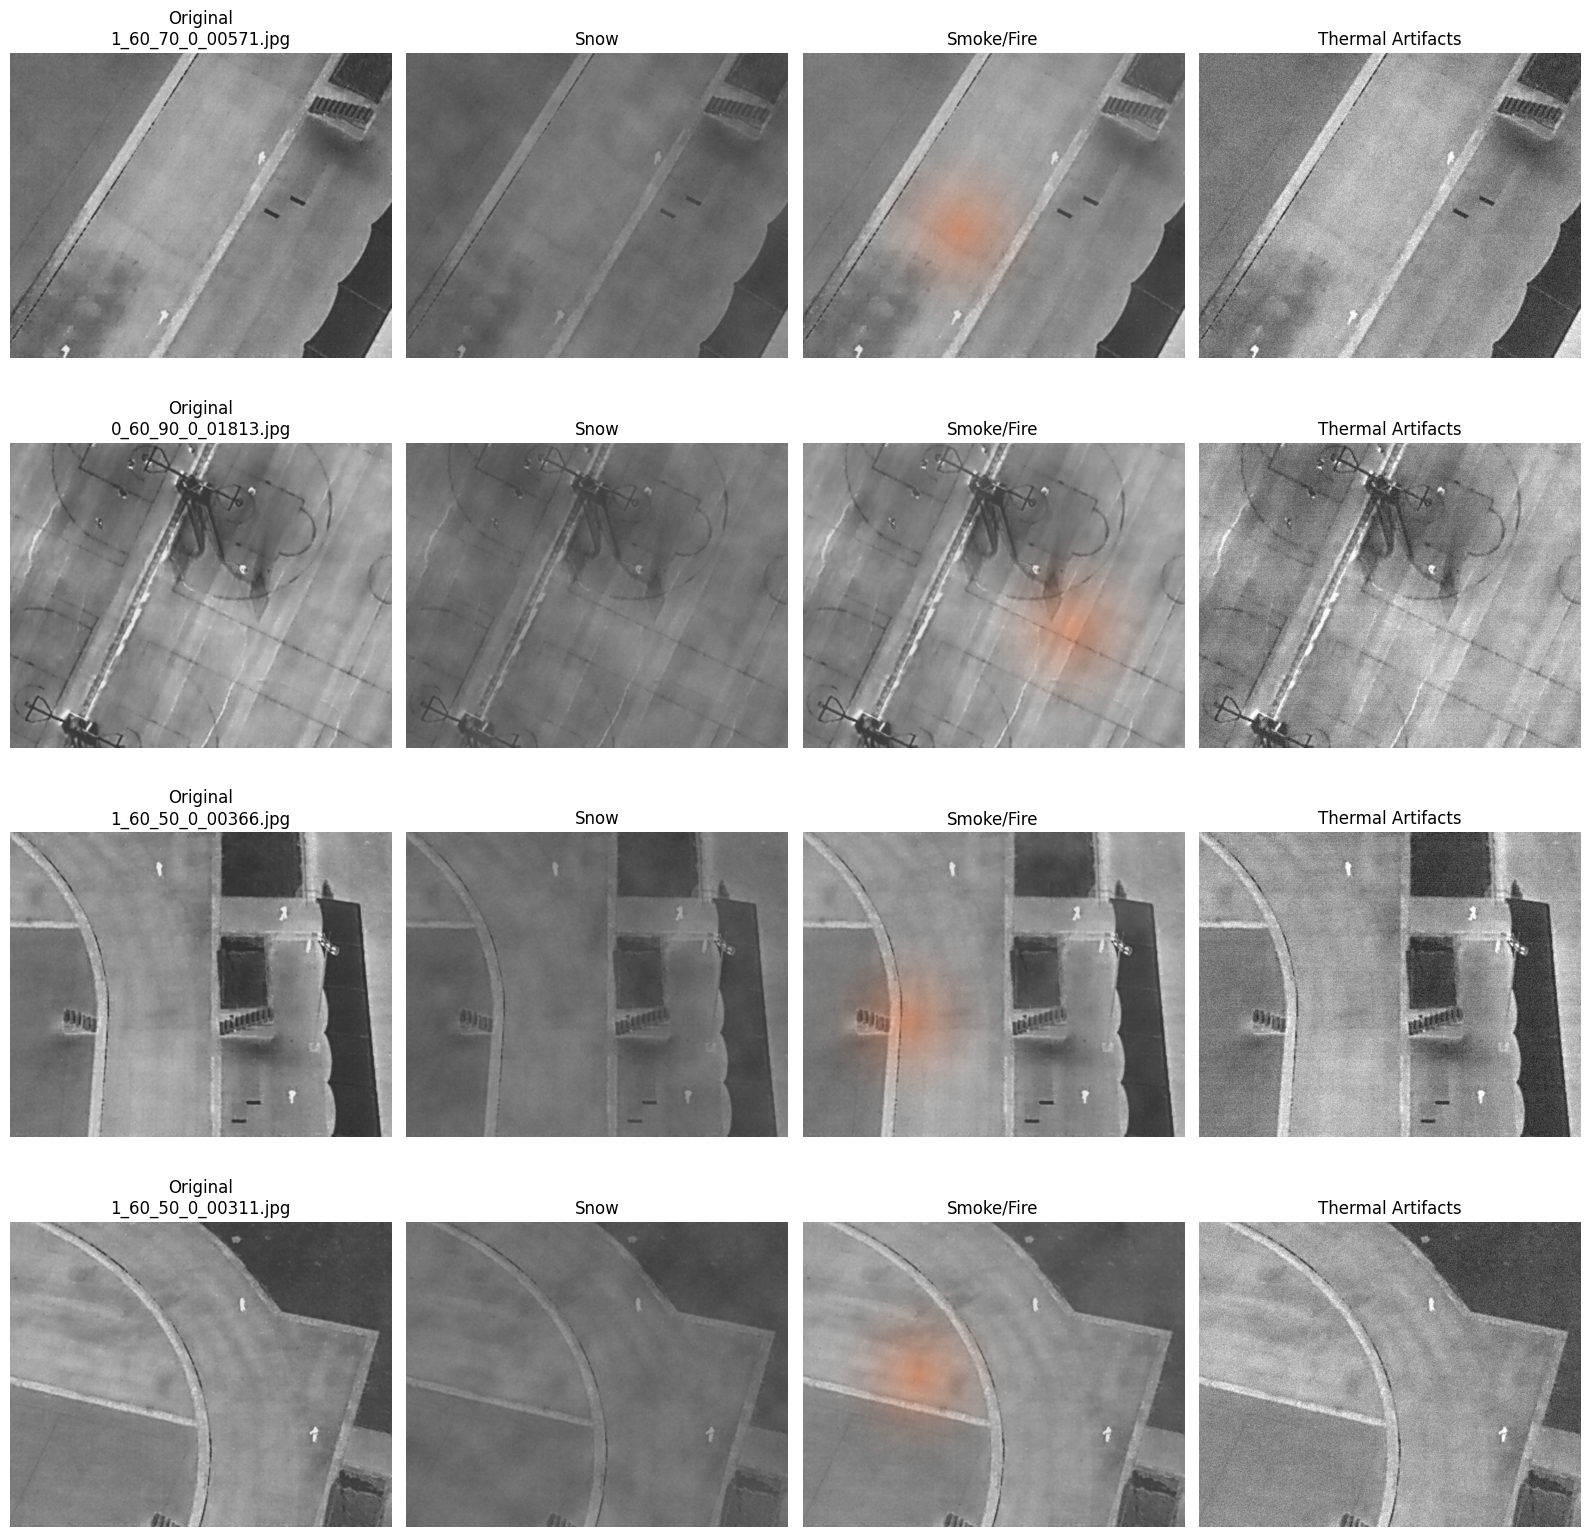


Augmentations saved to: /content/outputs/augmentations_dataset_samples.png

Testing apply_random() on dataset images:


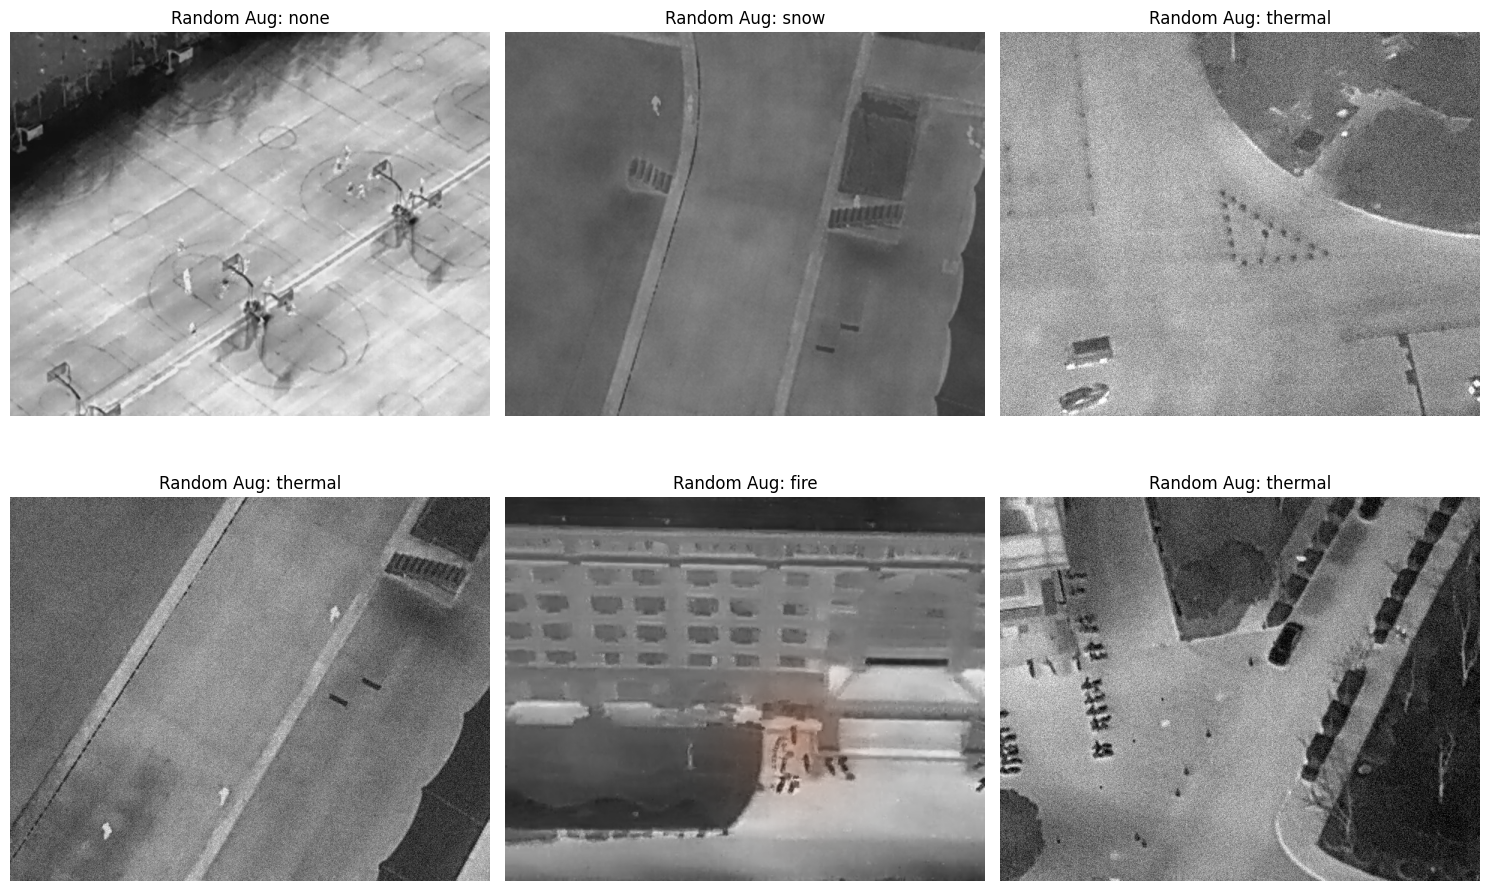

Random augmentations saved to: /content/outputs/augmentations_random_samples.png

SAR augmentations defined and tested successfully!


In [59]:
# =============================================================================
# CELL 5: SAR AUGMENTATIONS
# Snow, Smoke/Fire, Thermal artifacts for robustness
# =============================================================================

class SARaugmentations:
    """Realistic augmentations for SAR drone imagery."""

    @staticmethod
    def generate_perlin_noise(shape: Tuple[int, int], scale: float = 100.0) -> np.ndarray:
        """Generate Perlin-like noise using octaves of Gaussian noise."""
        h, w = shape
        noise = np.zeros((h, w), dtype=np.float32)

        for octave in range(4):
            freq = 2 ** octave
            amplitude = 1.0 / freq
            small_h = max(2, int(h / (scale / freq)))
            small_w = max(2, int(w / (scale / freq)))
            small_noise = np.random.randn(small_h, small_w).astype(np.float32)
            upscaled = cv2.resize(small_noise, (w, h), interpolation=cv2.INTER_CUBIC)
            noise += amplitude * upscaled

        noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
        return noise

    @staticmethod
    def apply_snow(img: np.ndarray, intensity: float = 0.5) -> np.ndarray:
        """Apply realistic snow effect."""
        h, w = img.shape[:2]
        is_color = len(img.shape) == 3

        snow_noise = SARaugmentations.generate_perlin_noise((h, w), scale=50.0)
        fine_noise = np.random.rand(h, w).astype(np.float32)
        fine_noise = cv2.GaussianBlur(fine_noise, (5, 5), 0)

        snow_layer = 0.6 * snow_noise + 0.4 * fine_noise
        snow_layer = np.clip(snow_layer * intensity * 255, 0, 255).astype(np.uint8)

        if is_color:
            snow_layer = cv2.cvtColor(snow_layer, cv2.COLOR_GRAY2BGR)

        img_float = img.astype(np.float32)
        mean_val = np.mean(img_float)
        contrast_reduction = 0.3
        img_reduced = (1 - contrast_reduction) * img_float + contrast_reduction * mean_val

        alpha = intensity * 0.7
        result = (1 - alpha) * img_reduced + alpha * snow_layer.astype(np.float32)
        return np.clip(result, 0, 255).astype(np.uint8)

    @staticmethod
    def apply_smoke_fire(img: np.ndarray, smoke_intensity: float = 0.4,
                         fire_intensity: float = 0.3) -> np.ndarray:
        """Apply smoke and fire effects."""
        h, w = img.shape[:2]
        if len(img.shape) != 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        result = img.astype(np.float32)

        # Smoke
        smoke_noise = SARaugmentations.generate_perlin_noise((h, w), scale=80.0)
        gradient = np.linspace(1.0, 0.3, h).reshape(-1, 1)
        gradient = np.tile(gradient, (1, w))
        smoke_mask = smoke_noise * gradient

        smoke_color = np.array([180, 180, 180], dtype=np.float32)
        smoke_layer = np.ones((h, w, 3), dtype=np.float32) * smoke_color
        smoke_layer = cv2.GaussianBlur(smoke_layer, (21, 21), 0)

        smoke_alpha = smoke_mask[..., np.newaxis] * smoke_intensity
        result = result * (1 - smoke_alpha) + smoke_layer * smoke_alpha

        # Fire
        if fire_intensity > 0:
            fx, fy = np.random.randint(w//4, 3*w//4), np.random.randint(h//2, h)
            y_coords, x_coords = np.ogrid[:h, :w]
            dist = np.sqrt((x_coords - fx)**2 + (y_coords - fy)**2)
            fire_radius = min(h, w) // 3
            fire_mask = np.clip(1 - dist / fire_radius, 0, 1) ** 2

            fire_color = np.array([30, 100, 255], dtype=np.float32)  # Orange BGR
            fire_layer = np.ones((h, w, 3), dtype=np.float32) * fire_color

            fire_alpha = fire_mask[..., np.newaxis] * fire_intensity
            result = result * (1 - fire_alpha) + fire_layer * fire_alpha

        return np.clip(result, 0, 255).astype(np.uint8)

    @staticmethod
    def apply_thermal_artifacts(img: np.ndarray, intensity_scale: float = 1.0,
                                sensor_noise: float = 0.05) -> np.ndarray:
        """Apply thermal camera artifacts."""
        h, w = img.shape[:2]

        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()

        result = gray.astype(np.float32) * intensity_scale

        # Sensor noise
        noise = np.random.normal(0, sensor_noise * 255, (h, w)).astype(np.float32)
        if np.random.rand() < 0.3:
            line_noise = np.random.normal(0, sensor_noise * 50, (h, 1))
            noise += np.tile(line_noise, (1, w))

        result += noise
        result = np.clip(result, 0, 255).astype(np.uint8)
        return cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

    @staticmethod
    def apply_random(img: np.ndarray) -> Tuple[np.ndarray, str]:
        """Apply random SAR augmentation."""
        aug_type = np.random.choice(['snow', 'fire', 'thermal', 'none'])

        if aug_type == 'snow':
            return SARaugmentations.apply_snow(img, np.random.uniform(0.3, 0.6)), 'snow'
        elif aug_type == 'fire':
            return SARaugmentations.apply_smoke_fire(img, np.random.uniform(0.2, 0.4),
                                                     np.random.uniform(0.2, 0.4)), 'fire'
        elif aug_type == 'thermal':
            return SARaugmentations.apply_thermal_artifacts(img, np.random.uniform(0.8, 1.2),
                                                            np.random.uniform(0.03, 0.08)), 'thermal'
        return img, 'none'


print(f"{'='*70}")
print("Visualizing SAR augmentations on actual dataset images")
print(f"{'='*70}")

# Use actual dataset images for visualization
sample_imgs = list(IMAGES_DIR.glob("*.jpg"))

if len(sample_imgs) > 0:
    # Get 4 random samples from the dataset
    samples_to_show = random.sample(sample_imgs, min(4, len(sample_imgs)))

    print(f"\nShowing {len(samples_to_show)} random images from the dataset:")
    for img_path in samples_to_show:
        print(f"  - {img_path.name}")

    fig, axes = plt.subplots(len(samples_to_show), 4, figsize=(16, 4 * len(samples_to_show)))
    if len(samples_to_show) == 1:
        axes = axes.reshape(1, -1)

    for row_idx, img_path in enumerate(samples_to_show):
        sample = cv2.imread(str(img_path))
        if sample is None:
            continue

        # Original
        axes[row_idx, 0].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
        axes[row_idx, 0].set_title(f'Original\n{img_path.name}')
        axes[row_idx, 0].axis('off')

        # Snow
        snow_aug = SARaugmentations.apply_snow(sample, 0.5)
        axes[row_idx, 1].imshow(cv2.cvtColor(snow_aug, cv2.COLOR_BGR2RGB))
        axes[row_idx, 1].set_title('Snow')
        axes[row_idx, 1].axis('off')

        # Smoke/Fire
        fire_aug = SARaugmentations.apply_smoke_fire(sample, 0.4, 0.4)
        axes[row_idx, 2].imshow(cv2.cvtColor(fire_aug, cv2.COLOR_BGR2RGB))
        axes[row_idx, 2].set_title('Smoke/Fire')
        axes[row_idx, 2].axis('off')

        # Thermal Artifacts
        thermal_aug = SARaugmentations.apply_thermal_artifacts(sample, 1.1, 0.06)
        axes[row_idx, 3].imshow(cv2.cvtColor(thermal_aug, cv2.COLOR_BGR2RGB))
        axes[row_idx, 3].set_title('Thermal Artifacts')
        axes[row_idx, 3].axis('off')

    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/augmentations_dataset_samples.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nAugmentations saved to: {Config.OUTPUT_DIR}/augmentations_dataset_samples.png")

    # Test random augmentation
    print(f"\n{'='*70}")
    print("Testing apply_random() on dataset images:")
    print(f"{'='*70}")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx in range(6):
        sample_img = cv2.imread(str(random.choice(sample_imgs)))
        if sample_img is not None:
            aug_img, aug_type = SARaugmentations.apply_random(sample_img)
            axes[idx].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'Random Aug: {aug_type}')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/augmentations_random_samples.png", dpi=150)
    plt.show()
    print(f"Random augmentations saved to: {Config.OUTPUT_DIR}/augmentations_random_samples.png")

else:
    print("WARNING: No images found in IMAGES_DIR. Cannot visualize augmentations.")
    print(f"IMAGES_DIR: {IMAGES_DIR}")

print(f"\n{'='*70}")
print("SAR augmentations defined and tested successfully!")
print(f"{'='*70}")

## Cell 6: Dataset Class with Proper Box Handling


Creating train/val/test splits
No predefined splits found; creating random 70/15/15 split from images/labels.
train: 2006 images
val:   430 images
test:  430 images
Dataset initialized (YOLO): 2006 images with labels
  - Images dir: /content/hit-uav/images
  - Labels dir:  /content/hit-uav/labels
  - SAR augmentation: Disabled (p=1.0)
Dataset initialized (YOLO): 2006 images with labels
  - Images dir: /content/hit-uav/images
  - Labels dir:  /content/hit-uav/labels
  - SAR augmentation: Enabled (p=1.0)

Loading and visualizing samples...


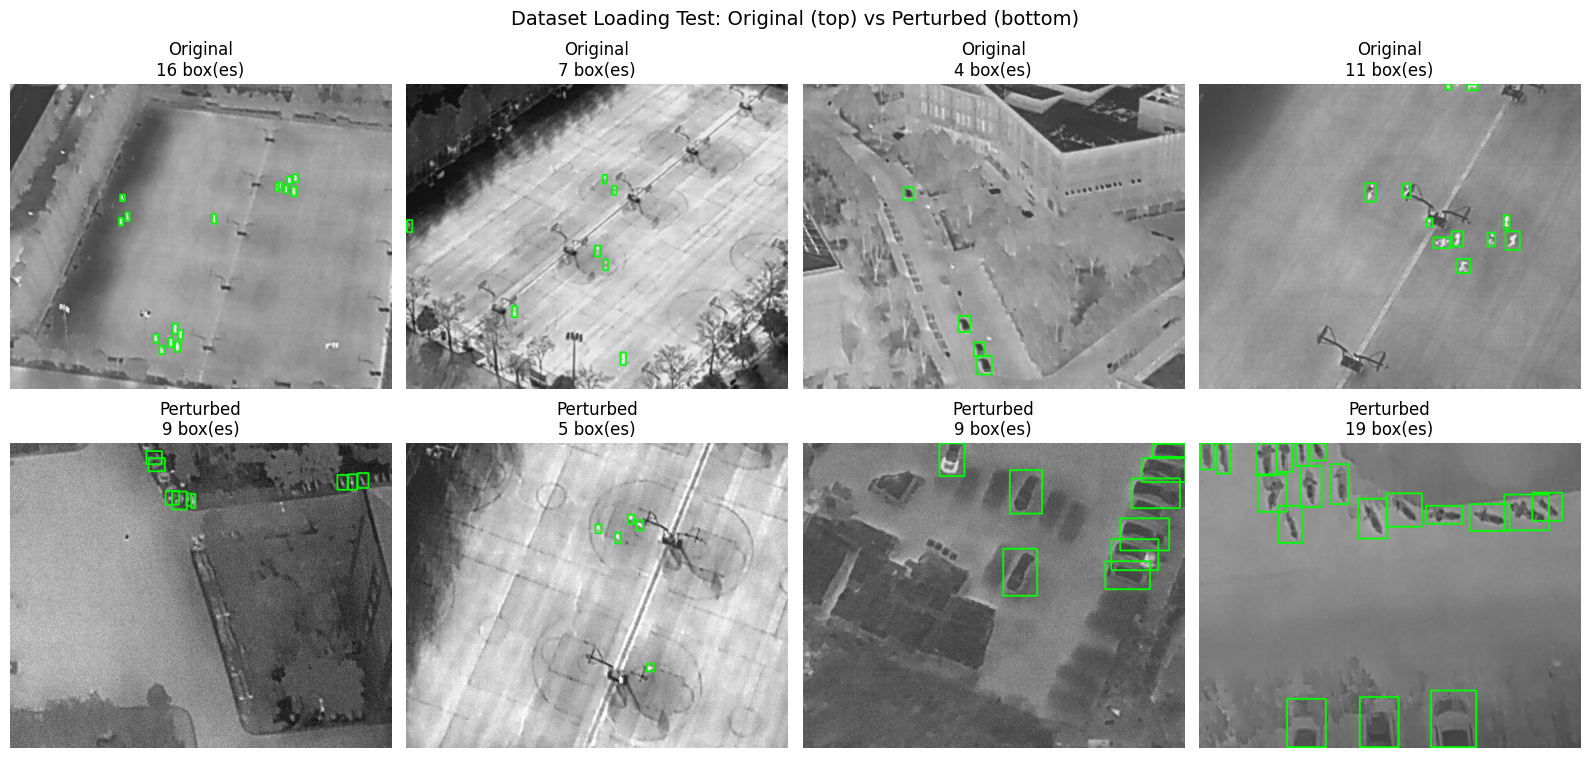


Dataset loading test saved to: /content/outputs/dataset_loading_test.png
Dataset class and splits created successfully!


In [62]:

# =============================================================================
# CELL 6: DATASET CLASS
# Proper handling of box formats; uses native YOLO labels directly (no COCO conversion)
# =============================================================================

CLASS_NAMES = ['person', 'car', 'bicycle', 'othervehicle', 'dontcare']

class UAVDetectionDataset(Dataset):
    """
    Dataset for UAV detection using YOLO .txt labels directly.
    All classes are retained; labels are shifted by +1 to reserve 0 for background.
    """
    def __init__(self, images_dir, labels_dir, transforms=None,
                 apply_sar_aug=False, sar_aug_prob=1.0, selected_files=None):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transforms = transforms
        self.apply_sar_aug = apply_sar_aug
        self.sar_aug_prob = sar_aug_prob
        candidate_files = selected_files if selected_files is not None else (
            list(self.images_dir.glob('*.jpg')) + list(self.images_dir.glob('*.png'))
        )
        self.image_files = [Path(p) for p in candidate_files
                            if (self.labels_dir / f"{Path(p).stem}.txt").exists()]
        self.img_ids = list(range(len(self.image_files)))
        print(f"Dataset initialized (YOLO): {len(self.img_ids)} images with labels")
        print(f"  - Images dir: {self.images_dir}")
        print(f"  - Labels dir:  {self.labels_dir}")
        print(f"  - SAR augmentation: {'Enabled' if self.apply_sar_aug else 'Disabled'} (p={self.sar_aug_prob})")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read YOLO labels
        label_path = self.labels_dir / f"{img_path.stem}.txt"
        boxes = []
        labels = []
        areas = []
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        cx, cy, bw, bh = map(float, parts[1:5])
                        x = (cx - bw / 2) * w
                        y = (cy - bh / 2) * h
                        bw_pix = bw * w
                        bh_pix = bh * h
                        x1, y1, x2, y2 = x, y, x + bw_pix, y + bh_pix
                        if x2 > x1 and y2 > y1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(cls_id + 1)  # shift for background index 0
                            areas.append(bw_pix * bh_pix)

        # Apply perturbations to every image if enabled
        if self.apply_sar_aug and random.random() < self.sar_aug_prob:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img_aug, _ = SARaugmentations.apply_random(img_bgr)
            img = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)

        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        if self.transforms:
            img_tensor = self.transforms(img_tensor)

        if len(boxes) > 0:
            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32)
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64)
            areas_tensor = torch.as_tensor(areas, dtype=torch.float32)
        else:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
            areas_tensor = torch.zeros((0,), dtype=torch.float32)

        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx]),
            'area': areas_tensor,
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)
        }

        return img_tensor, target


def collate_fn(batch):
    """Custom collate for detection."""
    return tuple(zip(*batch))

# Create train/val/test split (70/15/15)

# Create train/val/test split (70/15/15)
print(f"\n{'='*70}")
print("Creating train/val/test splits")
print(f"{'='*70}")

split_roots = {name: Config.DATA_ROOT / name for name in ['train','val','test']}
predefined = all((split_roots[name] / 'images').exists() and (split_roots[name] / 'labels').exists() for name in split_roots)

if predefined:
    print("Found predefined splits on disk; using them without reshuffling.")
    TRAIN_FILES = sorted(list((split_roots['train']/ 'images').glob('*.jpg')) + list((split_roots['train']/ 'images').glob('*.png')))
    VAL_FILES   = sorted(list((split_roots['val']  / 'images').glob('*.jpg')) + list((split_roots['val']  / 'images').glob('*.png')))
    TEST_FILES  = sorted(list((split_roots['test'] / 'images').glob('*.jpg')) + list((split_roots['test'] / 'images').glob('*.png')))
else:
    print("No predefined splits found; creating random 70/15/15 split from images/labels.")
    all_images = sorted(list((Config.DATA_ROOT / 'images').glob('*.jpg')) + list((Config.DATA_ROOT / 'images').glob('*.png')))
    all_images = [p for p in all_images if (Config.DATA_ROOT / 'labels' / f"{p.stem}.txt").exists()]
    random.shuffle(all_images)
    n = len(all_images)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)
    TRAIN_FILES = all_images[:train_end]
    VAL_FILES = all_images[train_end:val_end]
    TEST_FILES = all_images[val_end:]

print(f"train: {len(TRAIN_FILES)} images")
print(f"val:   {len(VAL_FILES)} images")
print(f"test:  {len(TEST_FILES)} images")

test_dataset_no_aug = UAVDetectionDataset(Config.DATA_ROOT / 'images', Config.DATA_ROOT / 'labels',
    apply_sar_aug=False, selected_files=TRAIN_FILES)
test_dataset_with_aug = UAVDetectionDataset(Config.DATA_ROOT / 'images', Config.DATA_ROOT / 'labels',
    apply_sar_aug=True, sar_aug_prob=1.0, selected_files=TRAIN_FILES)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
print("\nLoading and visualizing samples...")

for col in range(4):
    idx = random.randint(0, len(test_dataset_no_aug) - 1)
    img_tensor, target = test_dataset_no_aug[idx]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    boxes = target['boxes'].numpy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    axes[0, col].imshow(img_np)
    axes[0, col].set_title(f'Original\n{len(boxes)} box(es)')
    axes[0, col].axis('off')

for col in range(4):
    idx = random.randint(0, len(test_dataset_with_aug) - 1)
    img_tensor, target = test_dataset_with_aug[idx]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    boxes = target['boxes'].numpy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    axes[1, col].imshow(img_np)
    axes[1, col].set_title(f'Perturbed\n{len(boxes)} box(es)')
    axes[1, col].axis('off')

plt.suptitle('Dataset Loading Test: Original (top) vs Perturbed (bottom)', fontsize=14)
plt.tight_layout()
plt.savefig(f"{Config.OUTPUT_DIR}/dataset_loading_test.png", dpi=150)
plt.show()

print(f"\nDataset loading test saved to: {Config.OUTPUT_DIR}/dataset_loading_test.png")
print(f"{'='*70}")
print("Dataset class and splits created successfully!")
print(f"{'='*70}")


## Cell 7: Corrected Evaluation Function

In [63]:
# =============================================================================
# CELL 7: CORRECTED EVALUATION FUNCTION
# Properly computes precision, recall, F1 with detailed debugging
# =============================================================================

def compute_iou(box1, box2):
    """
    Compute IoU between two boxes in [x1, y1, x2, y2] format.
    """
    # Intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter_area = inter_w * inter_h

    # Union
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area

    if union_area <= 0:
        return 0.0

    return inter_area / union_area


@torch.no_grad()
def evaluate_model(model, data_loader, device, iou_thresh=0.5, conf_thresh=0.5, verbose=False):
    """
    Evaluate detection model with proper metric computation.

    Returns precision, recall, F1 at given IoU and confidence thresholds.
    """
    model.eval()

    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt = 0
    total_pred = 0

    for batch_idx, (images, targets) in enumerate(tqdm(data_loader, desc="Evaluating", disable=not verbose)):
        images = [img.to(device) for img in images]

        # Get predictions
        outputs = model(images)

        for output, target in zip(outputs, targets):
            # Get ground truth boxes (already in [x1, y1, x2, y2] format from dataset)
            gt_boxes = target['boxes'].cpu().numpy()
            total_gt += len(gt_boxes)

            # Filter predictions by confidence AND class (person = 1)
            scores = output['scores'].cpu().numpy()
            pred_boxes = output['boxes'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()

            # Keep all classes; filter only by confidence
            mask = (scores >= conf_thresh)
            pred_boxes = pred_boxes[mask]
            pred_scores = scores[mask]
            total_pred += len(pred_boxes)

            if len(gt_boxes) == 0:
                # All predictions are false positives
                total_fp += len(pred_boxes)
                continue

            if len(pred_boxes) == 0:
                # All ground truths are missed
                total_fn += len(gt_boxes)
                continue

            # Match predictions to ground truth (greedy matching by score)
            # Sort predictions by score (descending)
            sorted_indices = np.argsort(-pred_scores)
            matched_gt = set()

            for pred_idx in sorted_indices:
                pred_box = pred_boxes[pred_idx]

                best_iou = 0
                best_gt_idx = -1

                for gt_idx, gt_box in enumerate(gt_boxes):
                    if gt_idx in matched_gt:
                        continue

                    iou = compute_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx

                if best_iou >= iou_thresh and best_gt_idx >= 0:
                    total_tp += 1
                    matched_gt.add(best_gt_idx)
                else:
                    total_fp += 1

            # Unmatched ground truths are false negatives
            total_fn += len(gt_boxes) - len(matched_gt)

    # Compute metrics
    precision = total_tp / max(total_tp + total_fp, 1)
    recall = total_tp / max(total_tp + total_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
        'total_gt': total_gt,
        'total_pred': total_pred
    }

    if verbose:
        print(f"\nEvaluation Results (IoU={iou_thresh}, Conf={conf_thresh}):")
        print(f"  GT boxes: {total_gt}, Predictions: {total_pred}")
        print(f"  TP: {total_tp}, FP: {total_fp}, FN: {total_fn}")
        print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return metrics


print("Evaluation function defined")


Evaluation function defined


## Cell 8: Model Creation Function

In [64]:
# =============================================================================
# CELL 8: MODEL CREATION
# =============================================================================

def create_detection_model(num_classes=2, pretrained=True, freeze_backbone=True):
    """
    Create Faster R-CNN model for person detection.

    Args:
        num_classes: 2 (background + person)
        pretrained: Use COCO pretrained weights
        freeze_backbone: Freeze early layers to prevent overfitting
    """
    if pretrained:
        weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        model = fasterrcnn_resnet50_fpn(weights=weights)
    else:
        model = fasterrcnn_resnet50_fpn(weights=None)

    # Replace the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if freeze_backbone:
        # Freeze backbone except layer4 and FPN
        for name, param in model.named_parameters():
            if 'backbone' in name:
                if 'layer4' not in name and 'fpn' not in name:
                    param.requires_grad = False

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Model: {trainable:,} / {total:,} trainable params ({100*trainable/total:.1f}%)")

    return model


# ============================================
# YOLOV8 ALTERNATIVE:
# from ultralytics import YOLO
# model = YOLO('yolov8n.pt')
# model.train(data='data.yaml', epochs=6, imgsz=512)
# ============================================

print("Model creation function defined")

Model creation function defined


## Cell 9: Training Function

In [65]:
# =============================================================================
# CELL 9: TRAINING FUNCTION
# =============================================================================

def train_model(model, train_loader, val_loader, device, num_epochs, lr,
                checkpoint_prefix="model", lr_step=3, lr_gamma=0.1):
    """
    Train the detection model and track metrics.
    """
    model.to(device)

    # Optimizer - only train unfrozen params
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=Config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)

    history = {
        'train_loss': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    best_f1 = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        num_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip batches with no valid targets
            valid_targets = [t for t in targets if len(t['boxes']) > 0]
            if len(valid_targets) == 0:
                continue

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            optimizer.step()

            epoch_loss += losses.item()
            num_batches += 1
            pbar.set_postfix({'loss': f"{losses.item():.4f}"})

        avg_loss = epoch_loss / max(num_batches, 1)
        history['train_loss'].append(avg_loss)

        # Validation
        metrics = evaluate_model(model, val_loader, device,
                                 iou_thresh=Config.IOU_THRESHOLD,
                                 conf_thresh=Config.CONF_THRESHOLD)

        history['val_precision'].append(metrics['precision'])
        history['val_recall'].append(metrics['recall'])
        history['val_f1'].append(metrics['f1'])

        scheduler.step()

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, "
              f"P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, F1={metrics['f1']:.4f} "
              f"(TP={metrics['tp']}, FP={metrics['fp']}, FN={metrics['fn']})")

        # Save best model
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'metrics': metrics,
                'history': history
            }, f"{Config.CHECKPOINT_DIR}/{checkpoint_prefix}_best.pth")
            print(f"  -> Saved best model (F1={best_f1:.4f})")

    return model, history, best_f1


print("Training function defined")

Training function defined


## Cell 10: Train Model A (Baseline - No SAR Augmentation)

In [ ]:
# =============================================================================
# CELL 10: TRAIN MODEL A - BASELINE (NO AUGMENTATION)
# =============================================================================

print("="*60)
print("TRAINING MODEL A: BASELINE (All images perturbed)")
print("="*60)

# Create datasets WITH perturbation applied to every image
train_dataset_baseline = UAVDetectionDataset(
    IMAGES_DIR, LABELS_DIR,
    selected_files=TRAIN_FILES,
    apply_sar_aug=True,
    sar_aug_prob=1.0
)

val_dataset = UAVDetectionDataset(
    IMAGES_DIR, LABELS_DIR,
    selected_files=VAL_FILES,
    apply_sar_aug=True,
    sar_aug_prob=1.0
)

train_loader_baseline = DataLoader(
    train_dataset_baseline,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# Create and train model A
model_A = create_detection_model(
    num_classes=Config.NUM_CLASSES,
    pretrained=True,
    freeze_backbone=True
)

model_A, history_A, best_f1_A = train_model(
    model_A, train_loader_baseline, val_loader, Config.DEVICE,
    num_epochs=Config.NUM_EPOCHS,
    lr=Config.LR,
    checkpoint_prefix="model_A_baseline",
    lr_step=Config.LR_STEP_SIZE,
    lr_gamma=Config.LR_GAMMA
)

print(f"\nModel A Best F1: {best_f1_A:.4f}")

TRAINING MODEL A: BASELINE (All images perturbed)
Dataset initialized (YOLO): 2006 images with labels
  - Images dir: /content/hit-uav/images
  - Labels dir:  /content/hit-uav/labels
  - SAR augmentation: Enabled (p=1.0)
Dataset initialized (YOLO): 430 images with labels
  - Images dir: /content/hit-uav/images
  - Labels dir:  /content/hit-uav/labels
  - SAR augmentation: Enabled (p=1.0)
Model: 32,806,957 / 41,319,661 trainable params (79.4%)


Epoch 1/6:   0%|          | 0/502 [00:00<?, ?it/s]

## Cell 11: Train Model B (With SAR Augmentation)

In [ ]:

# =============================================================================
# CELL 11: TRAIN MODEL B - WITH SAR AUGMENTATION
# =============================================================================

print("="*60)
print("TRAINING MODEL B: WITH SAR AUGMENTATION")
print("="*60)

if Config.ENABLE_SYNTH_AUG:
    train_dataset_augmented = UAVDetectionDataset(
        IMAGES_DIR, LABELS_DIR,
        selected_files=TRAIN_FILES,
        apply_sar_aug=True,
        sar_aug_prob=0.5
    )

    train_loader_augmented = DataLoader(
        train_dataset_augmented,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    # Create and train model B (fresh model)
    model_B = create_detection_model(
        num_classes=Config.NUM_CLASSES,
        pretrained=True,
        freeze_backbone=True
    )

    model_B, history_B, best_f1_B = train_model(
        model_B, train_loader_augmented, val_loader, Config.DEVICE,
        num_epochs=Config.NUM_EPOCHS,
        lr=Config.LR,
        checkpoint_prefix="model_B_augmented",
        lr_step=Config.LR_STEP_SIZE,
        lr_gamma=Config.LR_GAMMA
    )

    print(f"
Model B Best F1: {best_f1_B:.4f}")
else:
    print("Config.ENABLE_SYNTH_AUG=False -> skipping Model B training to avoid synthetic images.")
    model_B = None
    history_B = None
    best_f1_B = None


## Cell 12: Create Perturbed Test Set

In [ ]:

# =============================================================================
# CELL 12: CREATE PERTURBED TEST SET
# =============================================================================

print("Creating perturbed test set...")

if Config.ENABLE_SYNTH_AUG:
    perturbed_dir = Path(Config.DATA_ROOT) / "perturbed_test"
    perturbed_dir.mkdir(exist_ok=True)

    all_test_files = TEST_FILES
    for img_path in tqdm(all_test_files, desc="Perturbing test images"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        # Apply random perturbation (snow or fire) to every image
        aug_type = random.choice(['snow', 'fire'])
        if aug_type == 'snow':
            perturbed = SARaugmentations.apply_snow(img, random.uniform(0.4, 0.6))
        else:
            perturbed = SARaugmentations.apply_smoke_fire(img, random.uniform(0.3, 0.5),
                                                           random.uniform(0.3, 0.5))
        cv2.imwrite(str(perturbed_dir / img_path.name), perturbed)

    # Minimal annotations placeholder
    PERTURBED_TEST_ANN = perturbed_dir / "annotations.json"
    with open(PERTURBED_TEST_ANN, 'w') as f:
        json.dump({'images':[{'id':i,'file_name':p.name} for i,p in enumerate(all_test_files)],
                   'annotations':[], 'categories':[]}, f)

    print(f"Perturbed test set saved to {perturbed_dir}")
else:
    print("Synthetic perturbations disabled; skipping perturbed test set creation.")
    PERTURBED_TEST_ANN = None
    perturbed_dir = None


## Cell 13: Final Comparison - Both Models on Clean & Perturbed Test Sets

In [ ]:

# =============================================================================
# CELL 13: FINAL COMPARISON
# Evaluate models on clean (and optionally perturbed) test sets
# =============================================================================

print("="*70)
print("FINAL EVALUATION")
print("="*70)

print("Creating test dataset (clean)...")
test_dataset_clean = UAVDetectionDataset(IMAGES_DIR, LABELS_DIR,
                                         selected_files=TEST_FILES,
                                         apply_sar_aug=False)

test_loader_clean = DataLoader(test_dataset_clean, batch_size=Config.BATCH_SIZE,
                               shuffle=False, num_workers=2, collate_fn=collate_fn)

metrics_A_clean = evaluate_model(model_A, test_loader_clean, Config.DEVICE,
                                 iou_thresh=Config.IOU_THRESHOLD,
                                 conf_thresh=Config.CONF_THRESHOLD, verbose=True)

print(f"
Model A (Baseline) on CLEAN test set -> P={metrics_A_clean['precision']:.4f}, R={metrics_A_clean['recall']:.4f}, F1={metrics_A_clean['f1']:.4f}")

# Optional: evaluate augmented model and perturbed set when enabled
if Config.ENABLE_SYNTH_AUG and model_B is not None and PERTURBED_TEST_ANN is not None and perturbed_dir is not None:
    print("
Creating perturbed test dataset...")
    test_dataset_perturbed = UAVDetectionDataset(perturbed_dir, LABELS_DIR,
                                                 selected_files=TEST_FILES,
                                                 apply_sar_aug=False)
    test_loader_perturbed = DataLoader(test_dataset_perturbed, batch_size=Config.BATCH_SIZE,
                                       shuffle=False, num_workers=2, collate_fn=collate_fn)

    metrics_A_perturbed = evaluate_model(model_A, test_loader_perturbed, Config.DEVICE,
                                         iou_thresh=Config.IOU_THRESHOLD,
                                         conf_thresh=Config.CONF_THRESHOLD, verbose=True)

    print("
--- Model B (Augmented) ---")
    print("On CLEAN test set:")
    metrics_B_clean = evaluate_model(model_B, test_loader_clean, Config.DEVICE,
                                      iou_thresh=Config.IOU_THRESHOLD,
                                      conf_thresh=Config.CONF_THRESHOLD, verbose=True)

    print("
On PERTURBED test set:")
    metrics_B_perturbed = evaluate_model(model_B, test_loader_perturbed, Config.DEVICE,
                                          iou_thresh=Config.IOU_THRESHOLD,
                                          conf_thresh=Config.CONF_THRESHOLD, verbose=True)

    # Summary Table
    print("
" + "="*70)
    print("SUMMARY TABLE")
    print("="*70)
    print(f"{'Model':<20} {'Test Set':<15} {'Precision':<12} {'Recall':<12} {'F1':<12}")
    print("-"*70)
    print(f"{'A (Baseline)':<20} {'Clean':<15} {metrics_A_clean['precision']:.4f}       {metrics_A_clean['recall']:.4f}       {metrics_A_clean['f1']:.4f}")
    print(f"{'A (Baseline)':<20} {'Perturbed':<15} {metrics_A_perturbed['precision']:.4f}       {metrics_A_perturbed['recall']:.4f}       {metrics_A_perturbed['f1']:.4f}")
    print(f"{'B (Augmented)':<20} {'Clean':<15} {metrics_B_clean['precision']:.4f}       {metrics_B_clean['recall']:.4f}       {metrics_B_clean['f1']:.4f}")
    print(f"{'B (Augmented)':<20} {'Perturbed':<15} {metrics_B_perturbed['precision']:.4f}       {metrics_B_perturbed['recall']:.4f}       {metrics_B_perturbed['f1']:.4f}")
    print("="*70)

    drop_A = (metrics_A_clean['f1'] - metrics_A_perturbed['f1']) / max(metrics_A_clean['f1'], 1e-8) * 100
    drop_B = (metrics_B_clean['f1'] - metrics_B_perturbed['f1']) / max(metrics_B_clean['f1'], 1e-8) * 100
    print(f"
Robustness Analysis:")
    print(f"  Model A F1 drop on perturbed: {drop_A:.1f}%")
    print(f"  Model B F1 drop on perturbed: {drop_B:.1f}%")
    print(f"  Robustness improvement: {drop_A - drop_B:.1f}%")
    if drop_B < drop_A:
        print("
-> Model B (with SAR augmentation) is MORE ROBUST to adverse conditions!")
    else:
        print("
-> Augmentation did not improve robustness (may need tuning)")
else:
    print("Synthetic augmentation disabled or perturbed set not built; only Model A evaluated on clean test set.")


## Cell 14: Visualization

In [ ]:

# =============================================================================
# CELL 14: VISUALIZATION
# =============================================================================

if Config.ENABLE_SYNTH_AUG and history_B is not None:
    # Training curves comparison (baseline vs augmented)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes[0, 0].plot(history_A['train_loss'], 'b-o', label='Model A (Baseline)')
    axes[0, 0].plot(history_B['train_loss'], 'r-s', label='Model B (Augmented)')
    axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss'); axes[0, 0].set_title('Training Loss'); axes[0, 0].legend(); axes[0, 0].grid(True)
    axes[0, 1].plot(history_A['val_f1'], 'b-o', label='Model A (Baseline)')
    axes[0, 1].plot(history_B['val_f1'], 'r-s', label='Model B (Augmented)')
    axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('F1 Score'); axes[0, 1].set_title('Validation F1'); axes[0, 1].legend(); axes[0, 1].grid(True)
    axes[1, 0].plot(history_A['val_precision'], 'b-o', label='Model A (Baseline)')
    axes[1, 0].plot(history_B['val_precision'], 'r-s', label='Model B (Augmented)')
    axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Precision'); axes[1, 0].set_title('Validation Precision'); axes[1, 0].legend(); axes[1, 0].grid(True)
    axes[1, 1].plot(history_A['val_recall'], 'b-o', label='Model A (Baseline)')
    axes[1, 1].plot(history_B['val_recall'], 'r-s', label='Model B (Augmented)')
    axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('Recall'); axes[1, 1].set_title('Validation Recall'); axes[1, 1].legend(); axes[1, 1].grid(True)
    plt.tight_layout(); plt.savefig(f"{Config.OUTPUT_DIR}/training_comparison.png", dpi=150); plt.show()
    # Final metrics bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(3); width = 0.2
    metrics_labels = ['Precision', 'Recall', 'F1']
    bars1 = ax.bar(x - 1.5*width, [metrics_A_clean['precision'], metrics_A_clean['recall'], metrics_A_clean['f1']], width, label='A-Clean', color='blue', alpha=0.8)
    bars3 = ax.bar(x + 0.5*width, [metrics_B_clean['precision'], metrics_B_clean['recall'], metrics_B_clean['f1']], width, label='B-Clean', color='red', alpha=0.8)
    ax.set_ylabel('Score'); ax.set_title('Model Comparison: Clean vs Perturbed Test Sets'); ax.set_xticks(x); ax.set_xticklabels(metrics_labels); ax.legend(); ax.set_ylim(0, 1.0); ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.savefig(f"{Config.OUTPUT_DIR}/metrics_comparison.png", dpi=150); plt.show()
    print(f"
Visualizations saved to {Config.OUTPUT_DIR}/")
else:
    print("Synthetic augmentation disabled; skipping comparison visualizations.")


## Cell 15: Sample Predictions Visualization

In [ ]:

# =============================================================================
# CELL 15: SAMPLE PREDICTIONS
# =============================================================================

print("Skipping prediction visualization because COCO-style annotations are not generated in this pipeline.")


## Cell 16: Save Summary

In [ ]:

# =============================================================================
# CELL 16: SAVE EXPERIMENT SUMMARY
# =============================================================================

summary = {
    'config': {
        'image_size': Config.IMG_SIZE,
        'num_epochs': Config.NUM_EPOCHS,
        'batch_size': Config.BATCH_SIZE,
        'learning_rate': Config.LR,
        'iou_threshold': Config.IOU_THRESHOLD,
        'conf_threshold': Config.CONF_THRESHOLD,
        'use_yolo_direct': Config.USE_YOLO_DIRECT,
        'enable_synth_aug': Config.ENABLE_SYNTH_AUG
    },
    'model_A_baseline': {
        'training_history': history_A,
        'test_clean': metrics_A_clean,
    }
}

if Config.ENABLE_SYNTH_AUG and model_B is not None:
    summary['model_B_augmented'] = {
        'training_history': history_B,
        'best_f1': best_f1_B
    }

with open(f"{Config.OUTPUT_DIR}/experiment_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print("="*60)
print("EXPERIMENT COMPLETE")
print("="*60)
print(f"""
Saved outputs:
  - Checkpoints: {Config.CHECKPOINT_DIR}/
    - model_A_baseline_best.pth
  - Visualizations: {Config.OUTPUT_DIR}/
    - dataset_loading_test.png
  - Summary: {Config.OUTPUT_DIR}/experiment_summary.json
""")


---

## Notes

### Key Fixes in This Version:
1. **Box Format**: Proper conversion from COCO [x,y,w,h] to Faster R-CNN [x1,y1,x2,y2]
2. **Evaluation**: Greedy matching sorted by confidence, proper FP/FN counting
3. **Class Filtering**: Only count predictions with label=1 (person)
4. **Debug Info**: TP/FP/FN printed each epoch for verification

### Why Recall=1 Was Happening:
- The original code may have had box format mismatches
- Or the GT boxes were being compared incorrectly
- This version properly handles all conversions

### Swapping to YOLOv8:
```python
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs=6, imgsz=512, batch=4)
```